In [1]:
import os
import pandas as pd
import numpy as np
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import geohexgrid as ghg
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import mapclassify

from scipy.stats import norm

from sklearn.neighbors import KernelDensity

## load underlying shapefile and generate grid

In [2]:
os.listdir('../data-week-01/')

['master-plan-2019-planningarea.cpg',
 'hdb_data_2023.csv.xz',
 'master-plan-2019-planningarea.prj',
 'master-plan-2019-planningarea.shp',
 'master-plan-2019-planningarea.shx',
 'hdb_data_2013.csv.xz',
 'master-plan-2019-planningarea.qmd',
 'master-plan-2019-planningarea.dbf']

<Axes: >

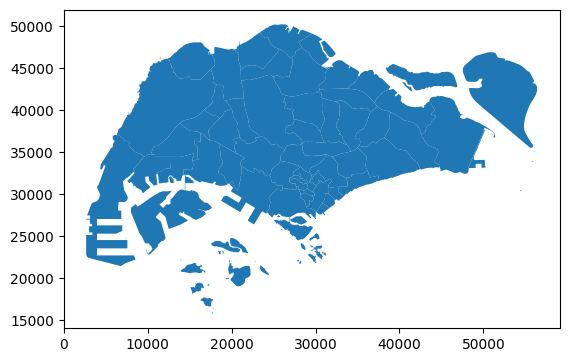

In [3]:
f = 'master-plan-2019-planningarea.shp'
pln = gpd.read_file('../data-week-01/master-plan-2019-planningarea.shp')
pln = pln.to_crs('epsg:3414')
pln.plot()

,geometry,index_right,Name,SUBZONE_NO,SUBZONE_N,SUBZONE_C,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,PA_Rakuten,X,Y
13,"POLYGON ((2667.538 22248.721, 3167.538 22248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,22498.721
14,"POLYGON ((2667.538 22748.721, 3167.538 22748.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,22998.721
15,"POLYGON ((2667.538 23248.721, 3167.538 23248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,23498.721
16,"POLYGON ((2667.538 23748.721, 3167.538 23748.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,23998.721
17,"POLYGON ((2667.538 24248.721, 3167.538 24248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,24498.721


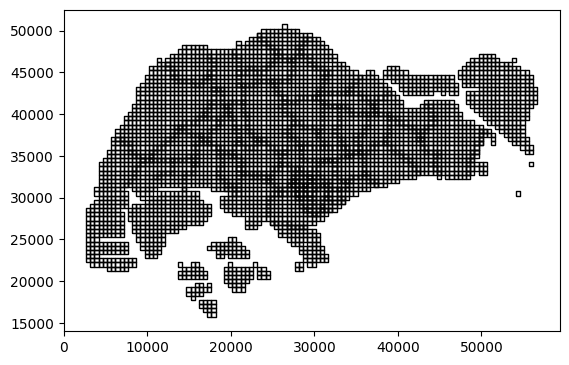

In [4]:
xmin, ymin, xmax, ymax = pln.total_bounds

length = 500
wide = 500

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
sq_grid = gpd.GeoDataFrame({'geometry':polygons}, crs='epsg:3414')
sq_grid = sq_grid.sjoin(pln)
sq_grid['X'] = [p.xy[0][0] for p in sq_grid.geometry.centroid]
sq_grid['Y'] = [p.xy[1][0] for p in sq_grid.geometry.centroid]
sq_grid.plot(fc='none', ec='k')
sq_grid.head()

In [128]:
#sq_xy = [(p.xy[0][0], p.xy[1][0]) for p in sq_grid.geometry.centroid]
#sq_grid['X'] = [p.xy[0][0] for p in sq_grid.geometry.centroid]
#sq_grid['X'] = [p.xy[1][0] for p in sq_grid.geometry.centroid]

## load point data (2013 and 2023) and plot

In [5]:
df_2013 = pd.read_csv('../data-week-01/hdb_data_2013.csv.xz')
df_2023 = pd.read_csv('../data-week-01/hdb_data_2023.csv.xz')

In [6]:
## this part is optional, for creating geodataframe from csv
gdf_2013 = gpd.GeoDataFrame(df_2013, 
    geometry=[Point(x,y) for x,y in zip(df_2013['X'], df_2013['Y'])], 
    crs='epsg:3414')
gdf_2023 = gpd.GeoDataFrame(df_2023, 
    geometry=[Point(x,y) for x,y in zip(df_2023['X'], df_2023['Y'])], 
    crs='epsg:3414')

<Axes: >

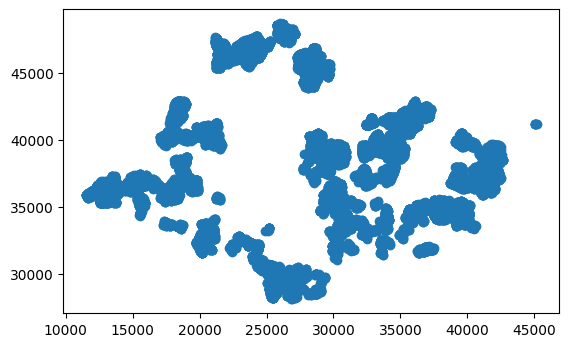

In [31]:
gdf_2013.plot()

<Axes: >

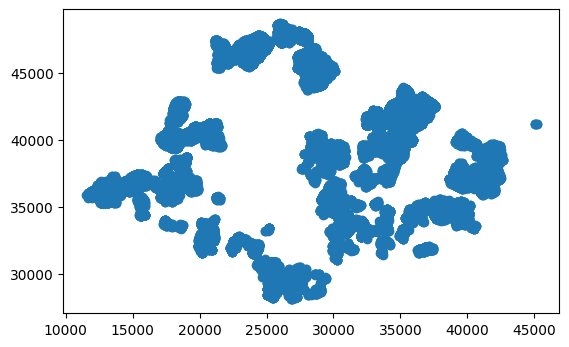

In [32]:
gdf_2023.plot()

## compare density estimated with Gaussian and Epanechnikov kernel functions, and different bandwidth, using square grid

In [7]:
## prepare point location data
Xdata13 = df_2013[['X', 'Y']]
Xdata23 = df_2023[['X', 'Y']]
Xdata13

,X,Y
0,29753.300929,39489.217940
1,29865.998046,38695.970271
2,29602.047153,38881.891694
3,28346.433332,39555.534275
4,28478.579445,39676.807613
...,...,...
16092,28270.473496,44364.763903
16093,27931.838896,45424.574197
16094,28807.426044,44617.934701
16095,28539.448693,44732.225912


In [8]:
kde13_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata13)
kde13_g1000

KernelDensity(bandwidth=1000)

In [10]:
sq_grid[['X', 'Y']]

,X,Y
13,2917.538,22498.721
14,2917.538,22998.721
15,2917.538,23498.721
16,2917.538,23998.721
17,2917.538,24498.721
...,...,...
7477,55917.538,44498.721
7541,56417.538,41498.721
7542,56417.538,41998.721
7543,56417.538,42498.721


<Axes: ylabel='Count'>

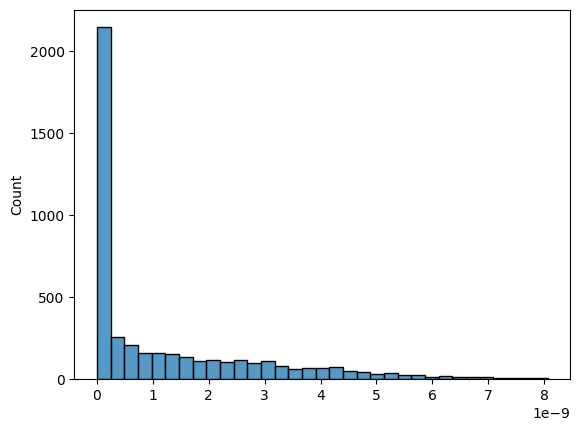

In [12]:
sns.histplot(np.exp(kde13_g1000.score_samples(sq_grid[['X', 'Y']])))

<Axes: >

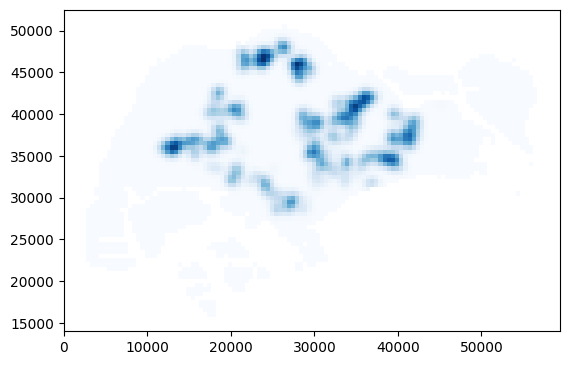

In [13]:
kde13_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata13)
kde13_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata13)
kde13_e1000 = KernelDensity(kernel='epanechnikov', bandwidth=1000).fit(Xdata13)
kde13_e500 = KernelDensity(kernel='epanechnikov', bandwidth=500).fit(Xdata13)
sq_grid['kde_13_g1k'] = np.exp(kde13_g1000.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_g5h'] = np.exp(kde13_g500.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_e1k'] = np.exp(kde13_e1000.score_samples(sq_grid[['X', 'Y']]))
sq_grid['kde_13_e5h'] = np.exp(kde13_e500.score_samples(sq_grid[['X', 'Y']]))
sq_grid.plot('kde_13_g5h', cmap='Blues')

In [14]:
sq_grid.head()

,geometry,index_right,Name,SUBZONE_NO,SUBZONE_N,SUBZONE_C,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,PA_Rakuten,X,Y,kde_13_g1k,kde_13_g5h,kde_13_e1k,kde_13_e5h
13,"POLYGON ((2667.538 22248.721, 3167.538 22248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,22498.721,3.826032e-65,2.325952e-228,0.0,0.0
14,"POLYGON ((2667.538 22748.721, 3167.538 22748.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,22998.721,2.529768e-62,4.159663e-217,0.0,0.0
15,"POLYGON ((2667.538 23248.721, 3167.538 23248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,23498.721,1.310043e-59,2.807754e-206,0.0,0.0
16,"POLYGON ((2667.538 23748.721, 3167.538 23748.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,23998.721,5.310084e-57,6.956505e-196,0.0,0.0
17,"POLYGON ((2667.538 24248.721, 3167.538 24248.7...",31,kml_112,3,TUAS NORTH,TSSZ03,TUAS,TS,WEST REGION,WR,TUAS,2917.538,24498.721,1.683856e-54,6.396304e-186,0.0,0.0


<Axes: >

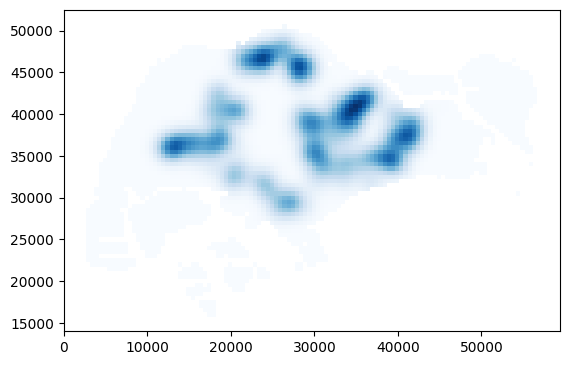

In [130]:
sq_grid.plot('kde_13_g1k', cmap='Blues')

<Axes: >

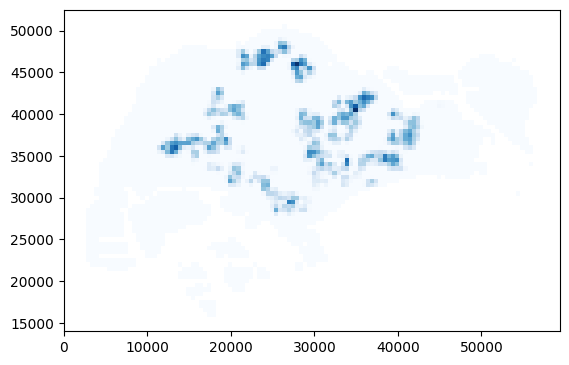

In [131]:
sq_grid.plot('kde_13_e5h', cmap='Blues')

<Axes: >

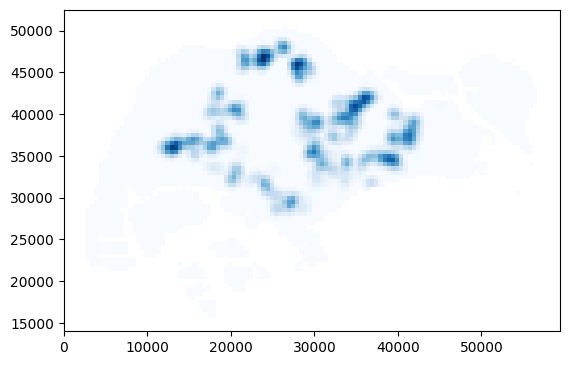

In [132]:
sq_grid.plot('kde_13_e1k', cmap='Blues')

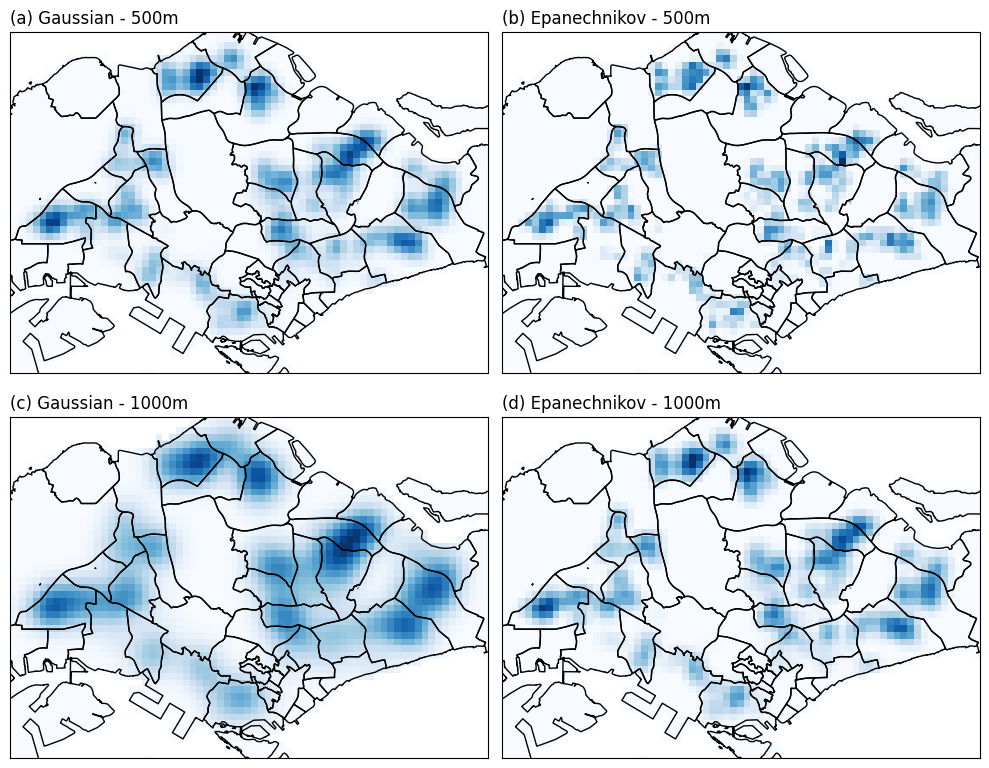

In [133]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

sq_grid.plot('kde_13_g5h', cmap='Blues', ax=axs[0])
sq_grid.plot('kde_13_e5h', cmap='Blues', ax=axs[1])
sq_grid.plot('kde_13_g1k', cmap='Blues', ax=axs[2])
sq_grid.plot('kde_13_e1k', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m',  'Epanechnikov - 500m', 
          'Gaussian - 1000m', 'Epanechnikov - 1000m']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

## generate hexagon grid

,cell_id,geometry,X,Y
21,"24,36","POLYGON ((17750.000 15155.445, 18250.000 15155...",18000.0,15588.457268
93,"23,37","POLYGON ((17000.000 15588.457, 17500.000 15588...",17250.0,16021.469970
94,"24,38","POLYGON ((17750.000 16021.470, 18250.000 16021...",18000.0,16454.482672
165,"22,40","POLYGON ((16250.000 16887.495, 16750.000 16887...",16500.0,17320.508076
166,"23,39","POLYGON ((17000.000 16454.483, 17500.000 16454...",17250.0,16887.495374


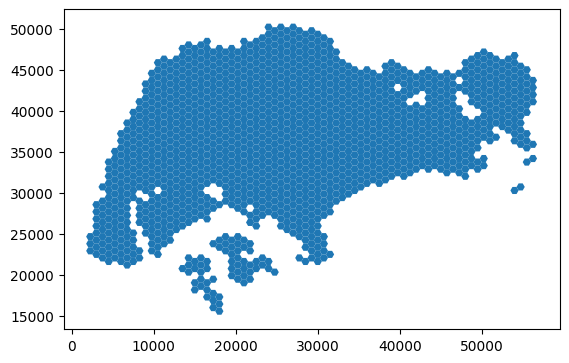

In [16]:
hex_grid = ghg.make_grid_from_gdf(pln, R=500)
hex_grid['X'] = [p.xy[0][0] for p in hex_grid.geometry.centroid]
hex_grid['Y'] = [p.xy[1][0] for p in hex_grid.geometry.centroid]
hex_grid.plot()
hex_grid.head()

## use Gaussian, different bandwidth, on the two years

In [17]:
kde13_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata13)
kde13_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata13)
kde23_g1000 = KernelDensity(kernel='gaussian', bandwidth=1000).fit(Xdata23)
kde23_g500 = KernelDensity(kernel='gaussian', bandwidth=500).fit(Xdata23)

hex_grid['kde_13_g1k'] = np.exp(kde13_g1000.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_13_g5h'] = np.exp(kde13_g500.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23_g1k'] = np.exp(kde23_g1000.score_samples(hex_grid[['X', 'Y']]))
hex_grid['kde_23_g5h'] = np.exp(kde23_g500.score_samples(hex_grid[['X', 'Y']]))

hex_grid.head()

,cell_id,geometry,X,Y,kde_13_g1k,kde_13_g5h,kde_23_g1k,kde_23_g5h
21,"24,36","POLYGON ((17750.000 15155.445, 18250.000 15155...",18000.0,15588.457268,4.889306e-57,2.670005e-196,3.903187e-57,1.495715e-196
93,"23,37","POLYGON ((17000.000 15588.457, 17500.000 15588...",17250.0,16021.469970,3.097931e-57,4.461857e-197,2.965172e-57,9.977547e-194
94,"24,38","POLYGON ((17750.000 16021.470, 18250.000 16021...",18000.0,16454.482672,1.931935e-52,6.234748e-178,1.724167e-52,4.676699e-178
165,"22,40","POLYGON ((16250.000 16887.495, 16750.000 16887...",16500.0,17320.508076,1.766298e-53,4.773359e-178,2.421332e-53,2.982837e-181
166,"23,39","POLYGON ((17000.000 16454.483, 17500.000 16454...",17250.0,16887.495374,8.481858e-53,2.359639e-179,9.214309e-53,4.450856e-179


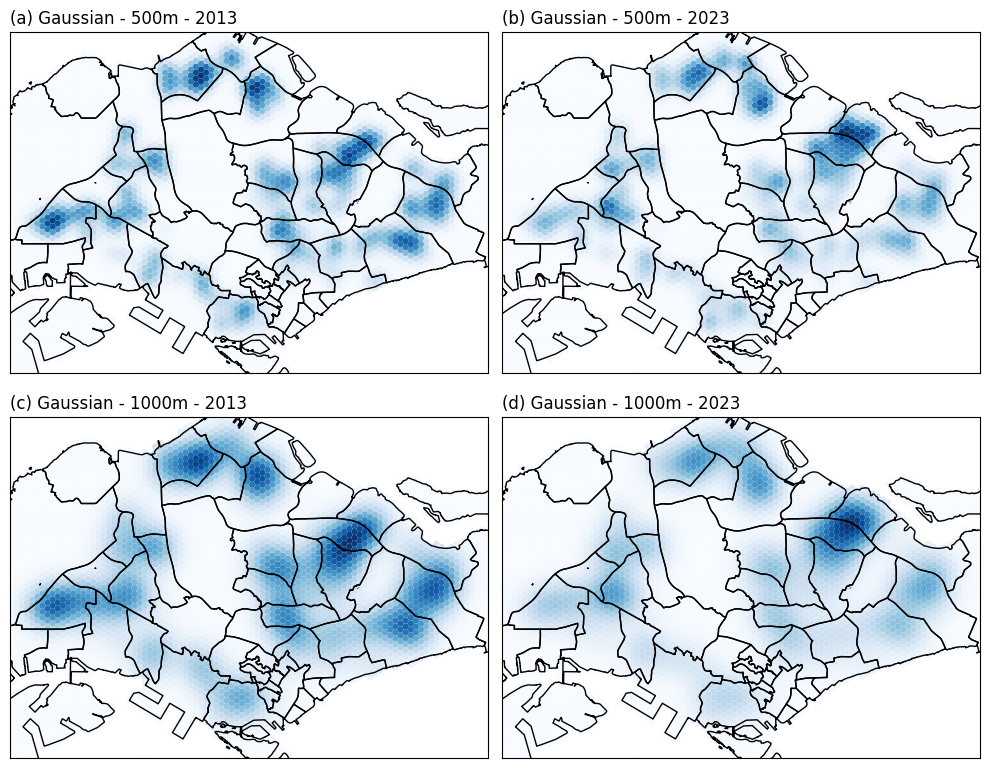

In [140]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot('kde_13_g5h', cmap='Blues', ax=axs[0])
hex_grid.plot('kde_23_g5h', cmap='Blues', ax=axs[1])
hex_grid.plot('kde_13_g1k', cmap='Blues', ax=axs[2])
hex_grid.plot('kde_23_g1k', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

the above plot the maps separately (which is fine), but hard to compare between map

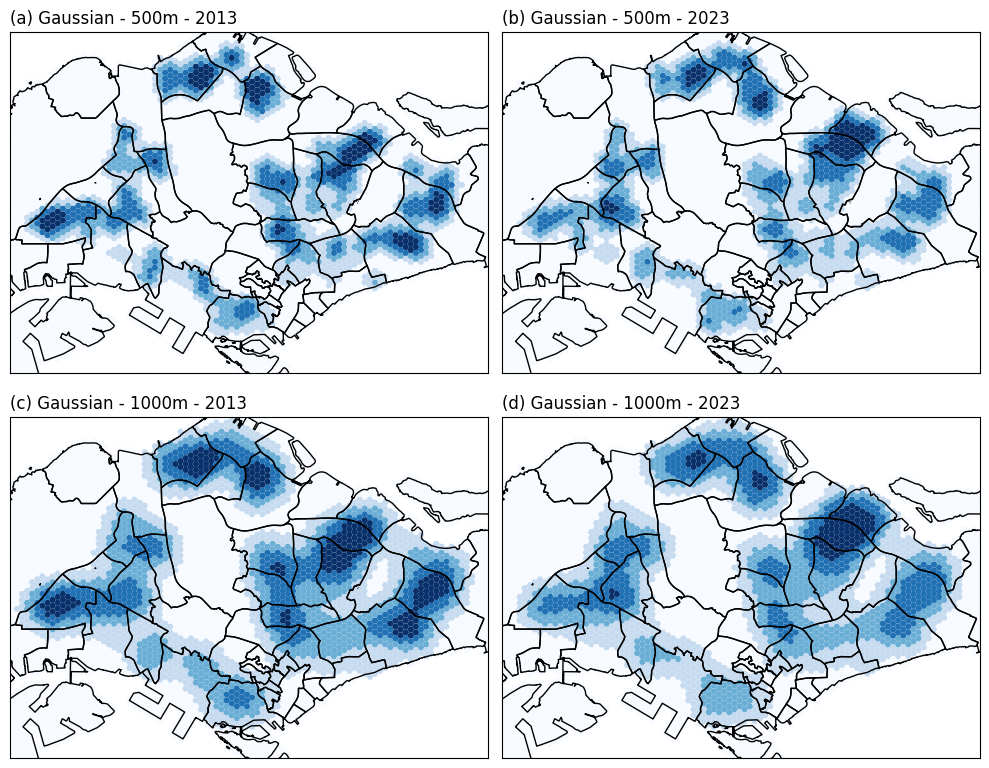

In [181]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot('kde_13_g5h', scheme='NaturalBreaks', cmap='Blues', ax=axs[0])
hex_grid.plot('kde_23_g5h', scheme='NaturalBreaks', cmap='Blues', ax=axs[1])
hex_grid.plot('kde_13_g1k', scheme='NaturalBreaks', cmap='Blues', ax=axs[2])
hex_grid.plot('kde_23_g1k', scheme='NaturalBreaks', cmap='Blues', ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

use a single shared break to differentiate colors

In [18]:
all_cols = ['kde_13_g5h', 'kde_13_g1k', 'kde_23_g5h', 'kde_23_g1k']
vs_all = []
for col in all_cols:
    v = hex_grid[col].tolist()
    vs_all.extend(v)
len(vs_all)
breaks = mapclassify.NaturalBreaks(vs_all, k=6)
print(breaks.bins)
#breaks
for col in all_cols:
    v = hex_grid[col].tolist()
    cut = mapclassify.UserDefined(v, bins=breaks.bins)
    yb = cut.yb
    #print(yb)
    hex_grid[col+'_cl'] = yb


[7.64702598e-10 2.30636834e-09 4.09792397e-09 6.28082484e-09
 9.54068375e-09 1.60145839e-08]


In [19]:
cmap = sns.color_palette('Blues', 6)
cmap2 = {i:[c] for i,c in enumerate(cmap)}
cmap

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

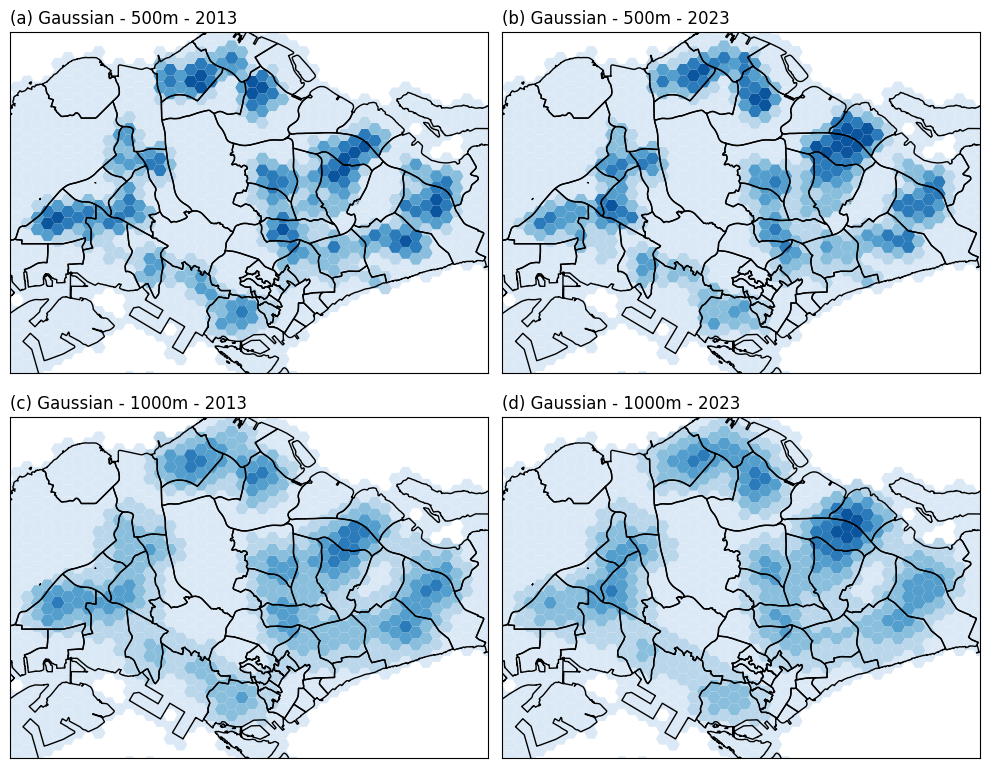

In [20]:
fig, axg = plt.subplots(2, 2, figsize=(10, 8))
axs = axg.flatten()

hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_13_g5h_cl']], ax=axs[0])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_23_g5h_cl']], ax=axs[1])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_13_g1k_cl']], ax=axs[2])
hex_grid.plot(fc=[cmap2[k] for k in hex_grid['kde_23_g1k_cl']], ax=axs[3])

titles = ['Gaussian - 500m - 2013',  'Gaussian - 500m - 2023', 
          'Gaussian - 1000m - 2013', 'Gaussian - 1000m - 2023']
labs = 'abcd'
for i, ax in enumerate(axs):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

## Dual Kernel Density Estimation

<Axes: >

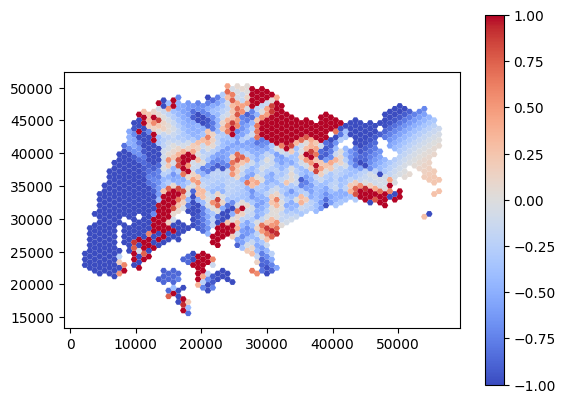

In [21]:
# dual kernel density estimation, log odds difference (magnitude of difference)
hex_grid['compared_5h'] = np.log2(hex_grid['kde_23_g5h'] / hex_grid['kde_13_g5h'])
hex_grid['compared_1k'] = np.log2(hex_grid['kde_23_g1k'] / hex_grid['kde_13_g1k'])

hex_grid.plot('compared_5h', cmap='coolwarm', legend=True, vmin=-1, vmax=1)

<Axes: >

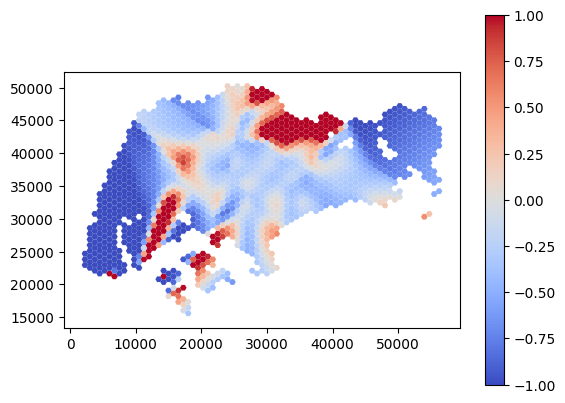

In [22]:
hex_grid.plot('compared_1k', cmap='coolwarm', legend=True, vmin=-1, vmax=1)

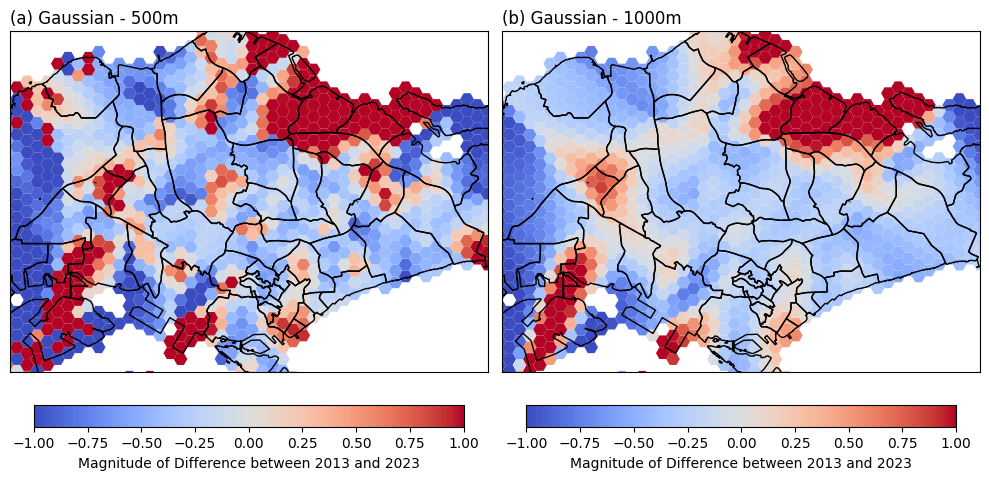

In [23]:
fig, axg = plt.subplots(1, 2, figsize=(10, 5))
axs = axg.flatten()

hex_grid.plot('compared_5h', cmap='coolwarm', legend=True, vmin=-1, vmax=1, ax=axs[0],
    legend_kwds={'label': "Magnitude of Difference between 2013 and 2023", 
        'orientation': "horizontal", "shrink":.9, "pad":0.07})
hex_grid.plot('compared_1k', cmap='coolwarm', legend=True, vmin=-1, vmax=1, ax=axs[1],
    legend_kwds={'label': "Magnitude of Difference between 2013 and 2023", 
        'orientation': "horizontal", "shrink":.9, "pad":0.07})

titles = ['Gaussian - 500m', 'Gaussian - 1000m']
labs = 'ab'
for i, ax in enumerate(axs[:2]):
    pln.plot(ax=ax, fc='none', ec='k')
    ax.set_xlim([10000, 45000])
    ax.set_ylim([25000, 50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('({}) {}'.format(labs[i], titles[i]), loc='left')

plt.tight_layout()

The log odds differences
$$\begin{aligned}
\text{Magnitude of Difference} &= \log_2 \frac{D_{2023}}{D_{2013}}\\
\frac{D_{2023}}{D_{2013}} &= 2^{\text{Magnitude of Difference}}
\end{aligned}$$

$$\begin{aligned}
MoD &= 1\\
\frac{D_{2023}}{D_{2013}} &= 2^1 \\
D_{2023} &= 2 \times D_{2013}
\end{aligned}$$

$$\begin{aligned}
MoD &= 0\\
\frac{D_{2023}}{D_{2013}} &= 2^{0} = 1\\
D_{2023} &= D_{2013}
\end{aligned}$$

$$\begin{aligned}
MoD &= -1\\
\frac{D_{2023}}{D_{2013}} &= 2^{-1}\\
D_{2023} &= 0.5 \times D_{2013}
\end{aligned}$$

Other approach: 
- absolute difference of density